In [197]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [198]:
# 计算成对的欧式距离
def pairwise_distances(Data):
    return np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))

def k_nearest_neighbors(Data, n_neighbors):
    dist_matrix = pairwise_distances(Data)
    return dist_matrix.argsort(axis=1)[:, 1:n_neighbors + 1]

In [199]:
# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data): 
    n = Data.shape[0] # 数据集的大小
    dist_matrix = pairwise_distances(Data) # 计算成对的欧式距离
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(dist_matrix[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')
    np.savetxt('average_radius.csv', radius, delimiter=',')
    return radius

In [200]:
# 以每个点k最近邻的平均距离作为每个数据点的半径
def compute_knn_average_radius(Data, dist_matrix, knn_matrix):
    n = Data.shape[0]
    avg_distances = np.zeros(n)
    for i in range(n):
        knn_indices = knn_matrix[i] # 第i个数据点的k个最近邻的索引
        knn_distances = [dist_matrix[i, idx] for idx in knn_indices] # 第i个数据点到k个最近邻的距离
        avg_distances[i] = np.mean(knn_distances) # 第i个数据点的k个最近邻的平均距离
    np.savetxt('knn_average_distances.csv', avg_distances, delimiter=',')
    return avg_distances

In [201]:
import heapq

# 使用优先队列（堆）实现 Dijkstra 算法
def dijkstra_shortest_path(graph, start):
    n = graph.shape[0]
    distances = np.full(n, np.inf)
    distances[start] = 0
    pq = [(0, start)]  # 优先队列，存储节点和对应的距离

    while pq:
        dist, current = heapq.heappop(pq)  # 弹出距离最小的节点
        if dist > distances[current]:
            continue
        for neighbor, weight in enumerate(graph[current]):
            if weight > 0 and dist + weight < distances[neighbor]:
                distances[neighbor] = dist + weight
                heapq.heappush(pq, (dist + weight, neighbor))  # 更新距离并入队

    return distances

# 以每个点到其他所有点的最短路径的平均值作为每个数据点的半径
def compute_avg_shortest_path(Data, knn_matrix):
    dist_matrix = pairwise_distances(Data)
    # 基于k最近邻图构建临时邻接矩阵 temp_adjacency_matrix
    temp_adjacency_matrix = np.zeros((len(Data), len(Data)))
    for i in range(len(Data)):
        for j in knn_matrix[i]:
            temp_adjacency_matrix[i][int(j)] = dist_matrix[i][int(j)]
            temp_adjacency_matrix[int(j)][i] = dist_matrix[int(j)][i]
    # 使用迪杰斯特拉算法计算最短路径并得到成对的测地距离 shortest_paths
    shortest_paths = np.zeros((len(Data), len(Data)))
    for i in range(len(Data)):
        shortest_paths[i] = dijkstra_shortest_path(temp_adjacency_matrix, i)
    # 计算每个数据点的平均最短路径
    avg_shortest_paths = np.zeros(len(Data))
    for i in range(len(Data)):
        avg_shortest_paths[i] = np.mean(shortest_paths[i])
    np.savetxt('shortest_paths.csv', shortest_paths, delimiter=',')
    np.savetxt('average_shortest_paths.csv', avg_shortest_paths, delimiter=',')
    return avg_shortest_paths

In [202]:
Pi = 3.14159265358979323846

# 函数1：计算k最近邻矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, n_neighbors):
    n = len(Data)
    distances = pairwise_distances(Data)  # 计算数据点间的成对欧式距离
    if method == 'knn':
        knn_matrix = k_nearest_neighbors(distances, n_neighbors)  # 计算每个样本点的 n_neighbors 个最近邻索引
        return knn_matrix
    elif method == 'epsilon':
        knn_matrix = k_nearest_neighbors(Data, n_neighbors)
        avg_shortest_paths = compute_avg_shortest_path(Data, knn_matrix)
        adjacency_matrix = np.zeros((n, n))
        #radius = compute_avg_radius(Data)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= avg_shortest_paths[i])[0]
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix


# 函数2：构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    neighborhood_matrix = compute_neighborhood_matrix(Data, method, n_neighbors)
    np.savetxt('neighborhood_matrix.csv', neighborhood_matrix, delimiter=',')
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    if method == 'knn':
        dist_matrix = pairwise_distances(Data)  # 计算数据集中样本点之间的距离
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in neighborhood_matrix[i]:  # 对于样本点 i 的邻居点 j
                Weight_matrix[i][int(j)] = np.exp(-dist_matrix[i][int(j)] ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                Weight_matrix[int(j)][i] = np.exp(-dist_matrix[int(j)][i] ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if neighborhood_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
    return Weight_matrix


In [203]:
# 进行特征映射
def eigen_mapping(Laplacian_matrix, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    return selected_eigenvectors

In [204]:
from sklearn.model_selection import KFold

# 其他函数保持不变

def select_best_n_neighbors(Data, n_components, t, method='knn', n_folds=5):
    """
    通过交叉验证选择最佳的 n_neighbors。

    Parameters
    ----------
    Data : array-like, shape (n_samples, n_features)
        输入数据。
    n_components : int
        特征映射后的维度。
    t : float
        热核参数。
    method : str, optional (default='knn')
        邻域方法，'knn' 或 'epsilon'。
    n_folds : int, optional (default=5)
        交叉验证的折数。

    Returns
    -------
    best_n_neighbors : int
        最佳的 n_neighbors 值。
    """
    if method != 'knn':
        raise ValueError("Method must be 'knn' for selecting n_neighbors.")

    kf = KFold(n_splits=n_folds)
    best_score = float('inf')
    best_n_neighbors = None

    for n_neighbors in range(150, 200):  # 尝试不同的 n_neighbors 值，范围为 1 到 20
        scores = []
        for train_index, _ in kf.split(Data):
            X_train = Data[train_index]
            Weight_matrix = construct_weight_matrix(X_train, method, n_neighbors, t)
            Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
            Laplacian_matrix = Degree_matrix - Weight_matrix
            selected_eigenvectors = eigen_mapping(Laplacian_matrix, n_components)
            # 计算评分，这里可以根据具体情况定义评分方式，例如投影后的数据的方差
            score = np.var(selected_eigenvectors)
            scores.append(score)
        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_n_neighbors = n_neighbors

    return best_n_neighbors

In [205]:
# LPP 算法
def LPP(Data, n_components, method, n_neighbors, t):
    # Step 1: 构建基于权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    np.savetxt('Weight_matrix.csv', Weight_matrix, delimiter=',')
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, n_components)
    return selected_eigenvectors

(-6.360909164736286,
 9.477276932362324,
 0.0010920470810349414,
 19.97190292286955,
 -4.814017829939432,
 7.916709742100855)

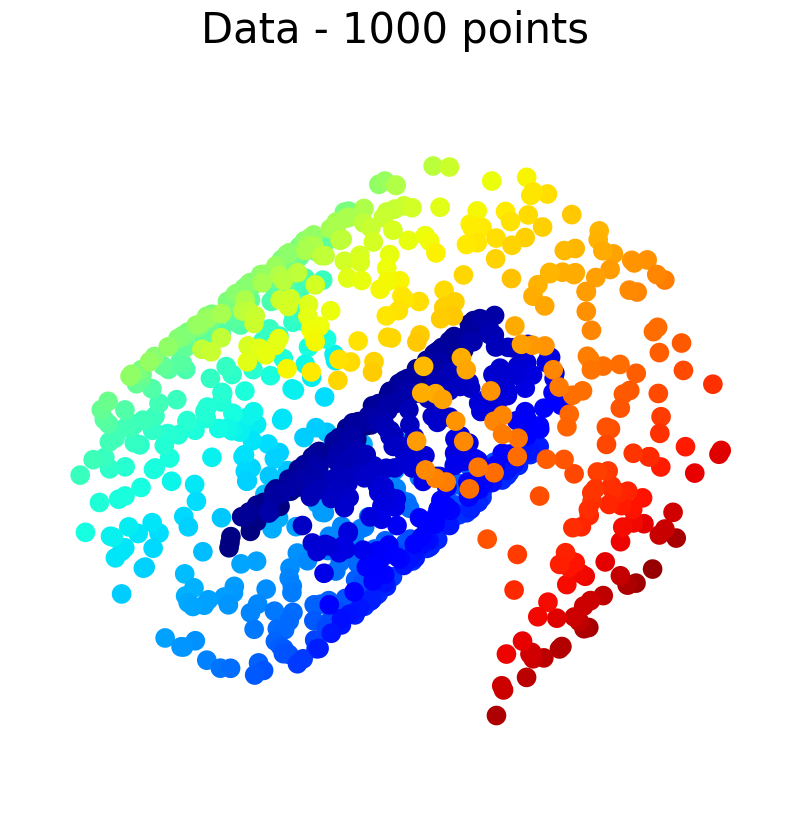

In [206]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)
# 绘制三维数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))
ax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))
ax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))
plt.title('Data - '+ str(Data.shape[1]) + ' points', size=30)
ax.axis("off")

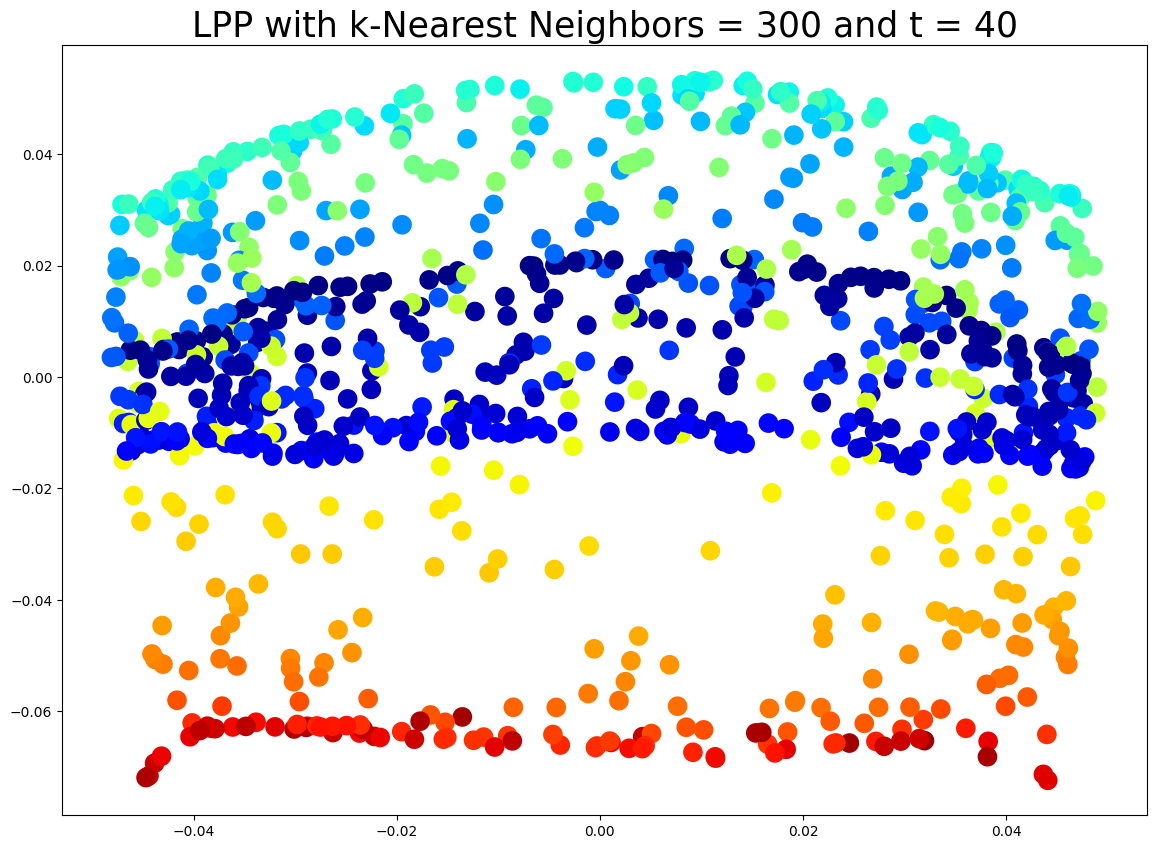

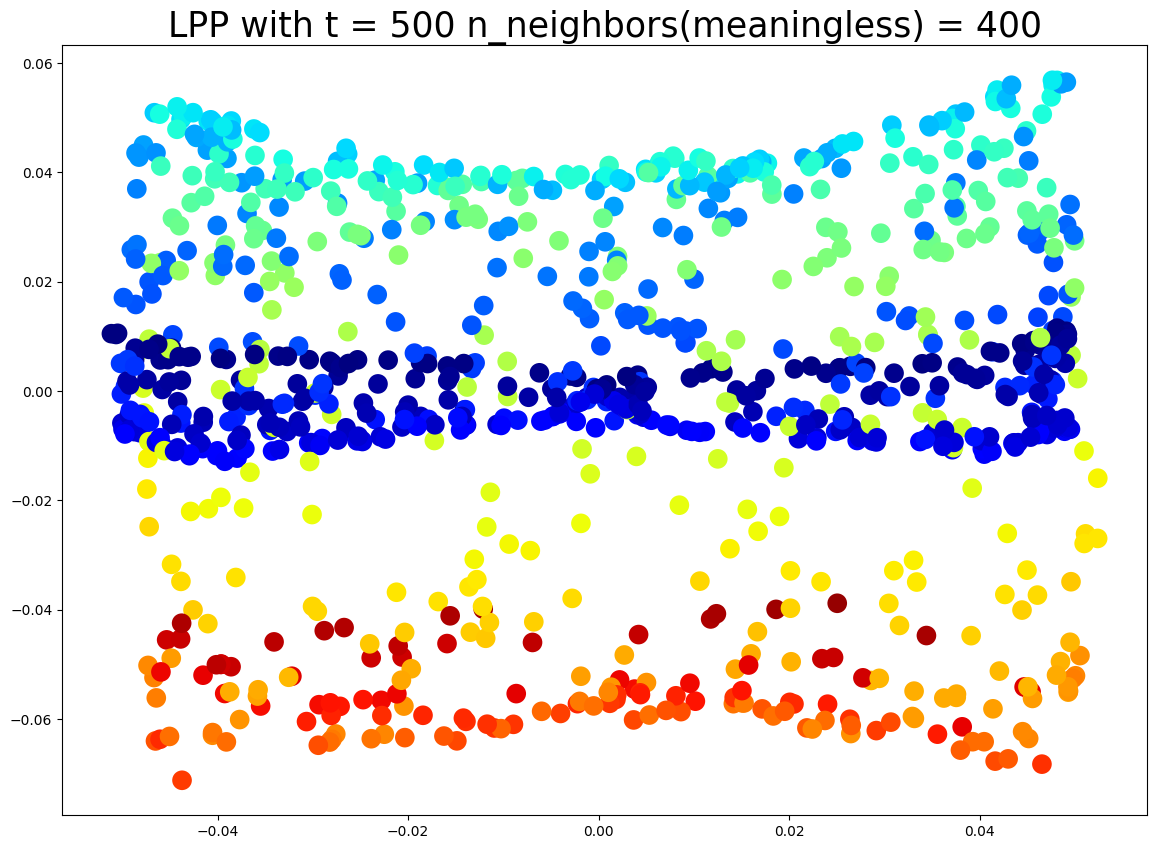

In [207]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['knn', 'epsilon']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        t= 500
        n_neighbors = 400
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP with t = ' + str(t) + ' n_neighbors(meaningless) = ' + str(n_neighbors), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        n_neighbors = 300
        t= 40
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(n_neighbors) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    plt.show()


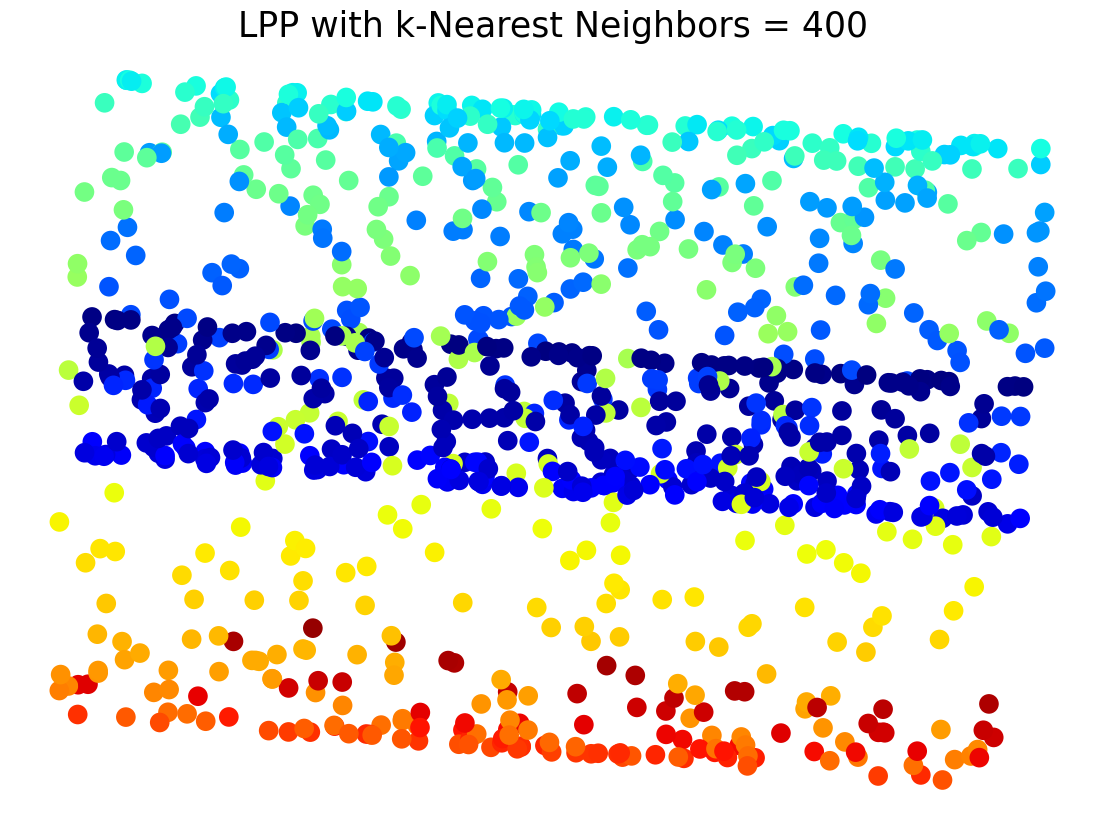

In [208]:
from myLPP import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components= 2)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)

# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors), size=25)
plt.axis("off")
plt.show()